# Shasta Reservoir Analysis: Uniform Monthly Release Assumption

## Introduction

This notebook analyzes the validity of the Uniform Monthly Release Assumption for the Shasta Reservoir. We compare daily and monthly release models to understand potential discrepancies in spill and penstock flow calculations.

Data Sources
1. Daily Release Data - https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations=SHA&SensorNums=23&dur_code=D&Start=1996-10-01&End=2023-09-30
2. Historic Water Year Types - https://cdec.water.ca.gov/reportapp/javareports?name=WSIHIST
3. Penstock Capacity - https://www.deltacouncil.ca.gov/pdf/science-program/review-materials/2022-07-14-bureau-of-reclamation-model-development.pdf (Page 38)


In [1]:
# Import Libraries and Load Data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Load daily release data 
# Note:- The input file Shasta_Outflow.xlsx should be in the same repo as this notebook. 
Shasta_Outflow = pd.read_excel('Shasta_Outflow.xlsx')
Shasta_Outflow = Shasta_Outflow[['OBS DATE', 'VALUE']]
Shasta_Outflow['VALUE'] = pd.to_numeric(Shasta_Outflow['VALUE'].str.replace(',', ''))
Shasta_Outflow['OBS DATE'] = pd.to_datetime(Shasta_Outflow['OBS DATE'])
Shasta_Outflow.set_index('OBS DATE', inplace=True)

C:\Users\amonkar\AppData\Local\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
# Load historic water year types
wy_types = pd.read_csv("Water_Year_Types.csv", index_col=0)
wy_types.index = pd.to_datetime(wy_types.index)
wy_types = wy_types[wy_types.index > '1996-09-30']
wy_types.index = wy_types.index + pd.offsets.MonthEnd(0)  # Align index to the end of the month

In [4]:
# Global parameters
shasta_penstock = 17600  # CFS
cfs_to_afd = 1.983  # Unit conversion CFS to AFD

## Analysis

### Daily Time Step Analysis

In [5]:
# Calculate daily spill
shasta_daily_spill = (Shasta_Outflow['VALUE'] - shasta_penstock).clip(lower=0)
shasta_daily_spill = shasta_daily_spill * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day
shasta_daily_spill = shasta_daily_spill.resample('M').sum()  # Aggregate to monthly

# Calculate daily penstock flow
shasta_daily_penstock = Shasta_Outflow['VALUE'].clip(upper=shasta_penstock)
shasta_daily_penstock = shasta_daily_penstock * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day
shasta_daily_penstock = shasta_daily_penstock.resample('M').sum()  # Aggregate to monthly

### Monthly Time Step Analysis

In [6]:
# Aggregate total releases to monthly time-step
shasta_monthly_flow = pd.DataFrame({
    'Flow': Shasta_Outflow['VALUE'].resample('M').sum(),  # Total Monthly Releases
    'DPM': Shasta_Outflow['VALUE'].resample('M').count()  # Days per month (Accounts for missing days as well)
})

# Calculate monthly spill
shasta_monthly_spill = (shasta_monthly_flow['Flow'] - shasta_monthly_flow['DPM'] * shasta_penstock).clip(lower=0)
shasta_monthly_spill = shasta_monthly_spill * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day

# Calculate monthly penstock flow
shasta_monthly_penstock = shasta_monthly_flow['Flow'].clip(upper=shasta_monthly_flow['DPM'] * shasta_penstock)
shasta_monthly_penstock = shasta_monthly_penstock * cfs_to_afd / 1000  # Convert to Thousand Acre-feet/day

## Metric Calculations

### Metric I: Underestimation of Spill

In [7]:
spill_underestimation = 100 * (sum(shasta_daily_spill) - sum(shasta_monthly_spill)) / sum(shasta_monthly_spill)
print(f'Underestimation of spill for Shasta: {round(spill_underestimation, 2)}%')

Underestimation of spill for Shasta: 79.13%


### Metric II: Overestimation of Penstock Flows

In [8]:
penstock_overestimation = 100 * (sum(shasta_monthly_penstock) - sum(shasta_daily_penstock)) / sum(shasta_daily_penstock)
print(f'Over-estimation of penstock flow for Shasta: {round(penstock_overestimation, 2)}%')

Over-estimation of penstock flow for Shasta: 3.93%


### Monthly Distribution of Penstock Flow Overestimation

In [9]:
penstock_overestimate = pd.DataFrame({
    'Daily': shasta_daily_penstock,
    'Monthly': shasta_monthly_penstock,
    'WYT': wy_types['SAC_Index']
})
penstock_overestimate['Month'] = penstock_overestimate.index.month

In [10]:
# Penstock overestimates in Jan-Apr
filtered_penstock_overestimate = penstock_overestimate[penstock_overestimate['Month'].isin([1, 2, 3, 4])]
jan_apr_overestimate = 100 * (filtered_penstock_overestimate['Monthly'].sum() - filtered_penstock_overestimate['Daily'].sum()) / filtered_penstock_overestimate['Daily'].sum()
print(f'Over-estimation of penstock flow for Shasta during Jan-Apr: {round(jan_apr_overestimate, 2)}%')

Over-estimation of penstock flow for Shasta during Jan-Apr: 12.28%


#### Function to create the monthly penstock flow overestimation table

In [11]:
def create_penstock_overestimate_table(penstock_overestimate):
    # Ensure the Month column is correctly formatted
    penstock_overestimate['Month'] = pd.to_datetime(penstock_overestimate.index).month
    
    # Function to calculate overestimate value
    def calculate_penstock_overestimate(group):
        daily_sum = group['Daily'].sum()
        monthly_sum = group['Monthly'].sum()
        return round(100 * (monthly_sum - daily_sum) / daily_sum, 2)
    
    # Calculate for all WYTs and Months
    months_by_wyt = penstock_overestimate.groupby(['WYT', 'Month']).apply(calculate_penstock_overestimate).reset_index(name='Calculation')
    
    # Create the pivot table
    pivot_table = months_by_wyt.pivot(index='WYT', columns='Month', values='Calculation')
    
    # Rename columns to month names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    pivot_table.columns = month_names
    
    # Calculate 'All Months' column
    all_months = penstock_overestimate.groupby('WYT').apply(calculate_penstock_overestimate)
    pivot_table['All Months'] = all_months
    
    # Calculate 'All Types' row
    all_types = penstock_overestimate.groupby('Month').apply(calculate_penstock_overestimate)
    all_types_row = pd.DataFrame(all_types).T
    all_types_row.index = ['All Types']
    all_types_row.columns = month_names
    all_types_row['All Months'] = calculate_penstock_overestimate(penstock_overestimate)
    
    # Combine all rows
    final_table = pd.concat([pivot_table, all_types_row])
    
    # Reorder columns to match the desired output
    column_order = ['All Months'] + month_names
    final_table = final_table[column_order]
    
    # Define the desired row order
    row_order = ['All Types', 'W', 'AN', 'BN', 'D', 'C']
    final_table = final_table.reindex(row_order)
    
    # Replace NaN with '-'
    final_table = final_table.replace(np.nan, '-')
    
    # Round non-dash values to integers
    final_table = final_table.applymap(lambda x: int(round(x)) if x != '-' else x)

    return final_table

In [12]:
#Values are in percentage (%)
create_penstock_overestimate_table(penstock_overestimate)

,All Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
All Types,4,8,11,22,7,2,0,0,0,0,0,0,5
W,8,16,10,31,14,1,0,0,0,0,0,0,10
AN,3,0,0,0,11,13,0,0,0,0,0,0,0
BN,3,0,37,21,0,3,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0


## Visual Analysis

### Spill Analysis Scatterplot

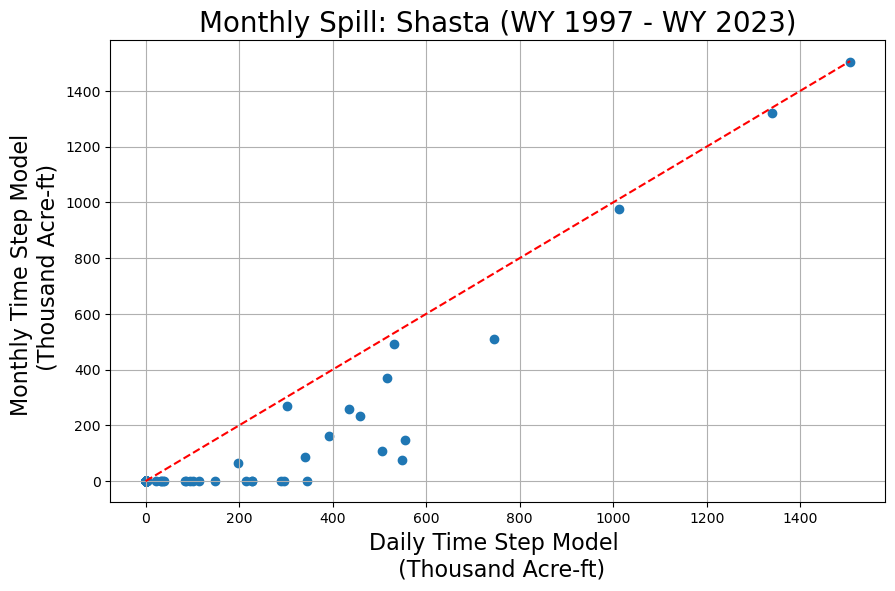

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(shasta_daily_spill, shasta_monthly_spill)
max_val = max(shasta_monthly_spill.max(), shasta_daily_spill.max())
min_val = min(shasta_monthly_spill.min(), shasta_daily_spill.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title('Monthly Spill: Shasta (WY 1997 - WY 2023)', fontsize=20)
plt.xlabel('Daily Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.ylabel('Monthly Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.grid(True)
plt.show()

### Penstock Flow Scatterplot

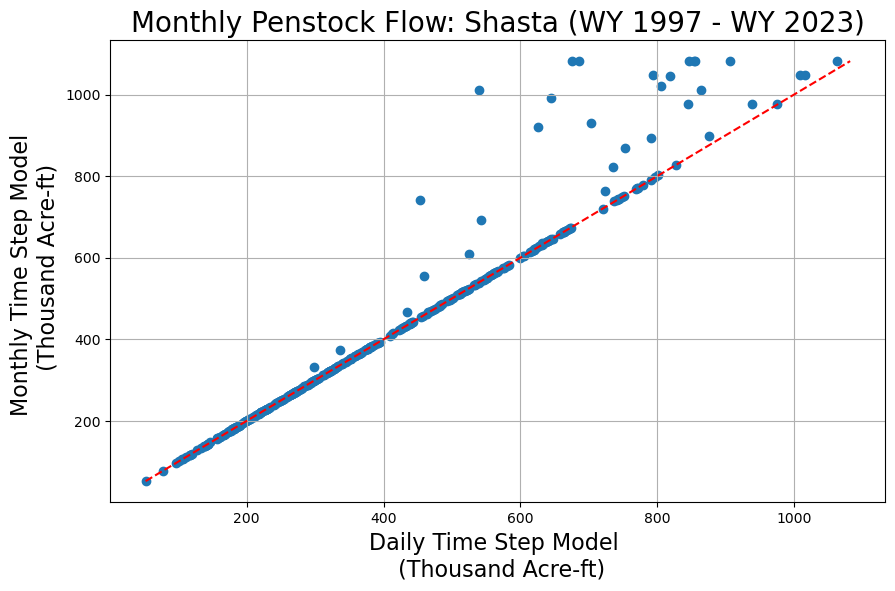

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(shasta_daily_penstock, shasta_monthly_penstock)
max_val = max(shasta_monthly_penstock.max(), shasta_daily_penstock.max())
min_val = min(shasta_monthly_penstock.min(), shasta_daily_penstock.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.title('Monthly Penstock Flow: Shasta (WY 1997 - WY 2023)', fontsize=20)
plt.xlabel('Daily Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.ylabel('Monthly Time Step Model \n (Thousand Acre-ft)', fontsize=16)
plt.grid(True)
plt.show()

### Monthly Counts of Spill Underestimation

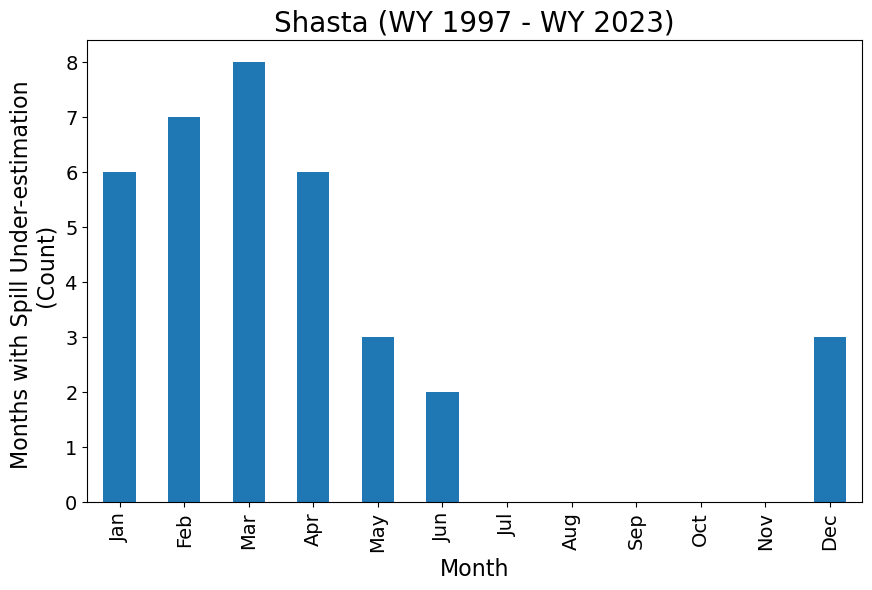

In [15]:
spill_difference = shasta_daily_spill - shasta_monthly_spill
non_zero_spill = spill_difference[spill_difference != 0]
non_zero_spill = non_zero_spill.reset_index()
non_zero_spill['Month'] = non_zero_spill['OBS DATE'].dt.strftime('%b')  # Extract month as a string
monthly_non_zero_count = non_zero_spill.groupby('Month').count()
monthly_non_zero_count = monthly_non_zero_count.reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

monthly_non_zero_count['OBS DATE'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month', fontsize=16)
plt.ylabel('Months with Spill Under-estimation \n (Count)', fontsize=16)
plt.title('Shasta (WY 1997 - WY 2023)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 2017 Jan - April Visual Analysis (Wet Water Year)

In [16]:
# Subset to needed timeframe
Shasta_Example = Shasta_Outflow * cfs_to_afd / 1000  # Convert to TAF
Shasta_Example = Shasta_Example['2017-01-01':'2017-04-30']

In [17]:
# Compute the Uniform Monthly Release Assumption Values
monthly_avg = Shasta_Example.resample('MS')['VALUE'].mean()
monthly_avg_daily = monthly_avg.reindex(Shasta_Example.index, method='ffill')
Shasta_Example['Monthly_Avg'] = monthly_avg_daily

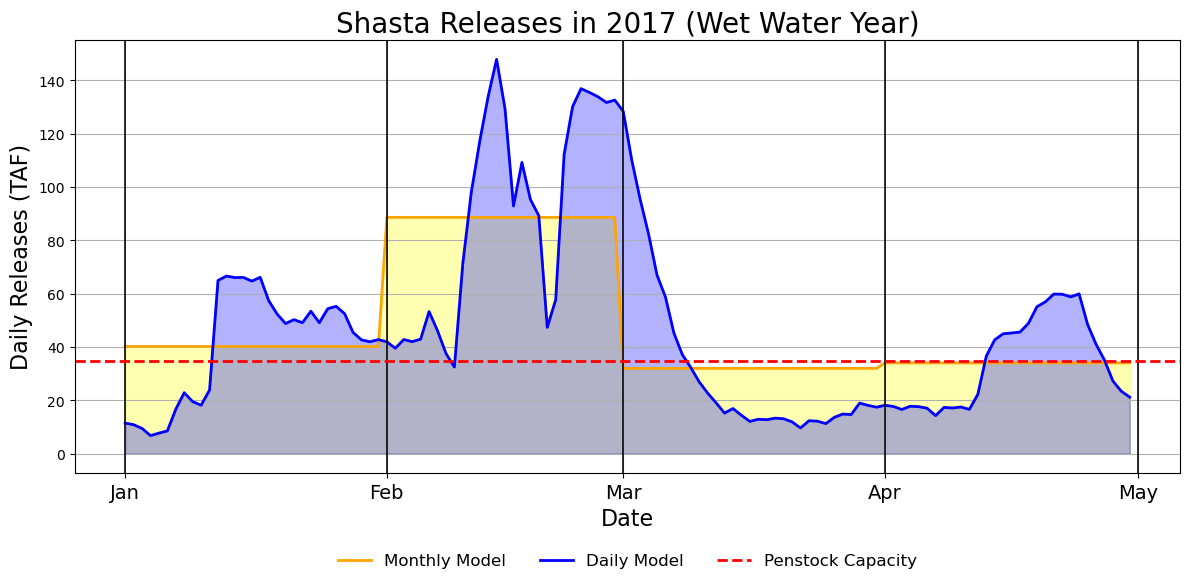

In [18]:
plt.figure(figsize=(12, 6))
plt.fill_between(Shasta_Example.index, Shasta_Example['Monthly_Avg'], 0, color='yellow', alpha=0.3)
plt.plot(Shasta_Example.index, Shasta_Example['Monthly_Avg'], linewidth=2, color='orange', label='Monthly Model')
plt.fill_between(Shasta_Example.index, Shasta_Example['VALUE'], 0, color='blue', alpha=0.3)
plt.plot(Shasta_Example.index, Shasta_Example['VALUE'], linewidth=2, color='blue', label='Daily Model')
plt.title('Shasta Releases in 2017 (Wet Water Year)', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Daily Releases (TAF)', fontsize=16)
for month in pd.date_range(start='2017-01-01', end='2017-05-01', freq='MS'):
    plt.axvline(x=month, color='black', linewidth=1.15)
plt.axhline(y=shasta_penstock * cfs_to_afd / 1000, color='red', linestyle='--', linewidth=2, label='Penstock Capacity')
plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center', fontsize=14)
plt.tight_layout()
plt.show()